In [100]:
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

In [24]:
IMAGE_SIZE = (100, 100)
BATCH_SIZE = 60
EPOCHS = 5

In [3]:
covid_df_orig = pd.read_pickle('./covid_df.pkl')
covid_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 126
Data columns (total 16 columns):
Patientid         76 non-null int64
offset            56 non-null float64
sex               67 non-null object
age               63 non-null float64
finding           76 non-null object
survival          29 non-null object
view              76 non-null object
date              76 non-null object
location          60 non-null object
filename          76 non-null object
doi               44 non-null object
 url              76 non-null object
license           14 non-null object
clinical notes    71 non-null object
other notes       32 non-null object
Unnamed: 15       0 non-null float64
dtypes: float64(3), int64(1), object(12)
memory usage: 10.1+ KB


In [4]:
covid_df, covid_df_val, d1, d2 = train_test_split(covid_df_orig, covid_df_orig, test_size=0.1, random_state=42)
covid_df.shape, covid_df_val.shape

((68, 16), (8, 16))

In [5]:
rsna_df_orig = pd.read_pickle('./rsna_df.pkl')
rsna_df_orig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20672 entries, 0 to 30224
Data columns (total 8 columns):
patientId    20672 non-null object
x            0 non-null float64
y            0 non-null float64
width        0 non-null float64
height       0 non-null float64
Target       20672 non-null int64
filename     20672 non-null object
is_covid     20672 non-null int64
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


In [6]:
rsna_df, rsna_df_val, d1, d2 = train_test_split(rsna_df_orig, rsna_df_orig, test_size=0.1, random_state=42)
rsna_df.shape, rsna_df_val.shape

((18604, 8), (2068, 8))

In [49]:
class Covid19SiameseDataSet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.imageFolder = root_dir
        self.transform = transform
        
    def __getitem__(self, index):
        get_same_class = random.randint(0,1)
        label = None
        img_0 = None
        img_1 = None
        if(get_same_class):
            label = 1
            if(random.randint(0,1)):
                img_0 = rsna_df.filename.sample(1).values[0]
                img_1 = rsna_df.filename.sample(1).values[0]
            else:
                img_0 = covid_df.filename.sample(1).values[0]
                img_1 = covid_df.filename.sample(1).values[0]
        else:
            label = 0
            if(random.randint(0,1)):
                img_0 = covid_df.filename.sample(1).values[0]
                img_1 = rsna_df.filename.sample(1).values[0]
            else:
                img_0 = rsna_df.filename.sample(1).values[0]
                img_1 = covid_df.filename.sample(1).values[0]
        
        img_0 = Image.open(self.imageFolder+img_0)
        img_1 = Image.open(self.imageFolder+img_1)
        img_0 = img_0.convert("L")
        img_1 = img_1.convert("L")
        
        if(self.transform is not None):
            img_0 = self.transform(img_0)
            img_1 = self.transform(img_1)
        
        return img_0, img_1, torch.from_numpy(np.array(label, dtype=np.float32))
    
    def __len__(self):
        return len(os.listdir(self.imageFolder))

In [50]:
class Covid19SiameseDataSet_val(Dataset):
    def __init__(self, root_dir, transform=transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                                               transforms.ToTensor()
                                                              ])):
        self.imageFolder = root_dir
        self.transform = transform
        
    def __getitem__(self, index):
        get_same_class = random.randint(0,1)
        label = None
        img_0 = None
        img_1 = None
        if(get_same_class):
            label = 1
            if(random.randint(0,1)):
                img_0 = rsna_df_val.filename.sample(1).values[0]
                img_1 = rsna_df_val.filename.sample(1).values[0]
            else:
                img_0 = covid_df_val.filename.sample(1).values[0]
                img_1 = covid_df_val.filename.sample(1).values[0]
        else:
            label = 0
            if(random.randint(0,1)):
                img_0 = covid_df_val.filename.sample(1).values[0]
                img_1 = rsna_df_val.filename.sample(1).values[0]
            else:
                img_0 = rsna_df_val.filename.sample(1).values[0]
                img_1 = covid_df_val.filename.sample(1).values[0]
        
        img_0 = Image.open(self.imageFolder+img_0)
        img_1 = Image.open(self.imageFolder+img_1)
        img_0 = img_0.convert("L")
        img_1 = img_1.convert("L")
        
        if(self.transform is not None):
            img_0 = self.transform(img_0)
            img_1 = self.transform(img_1)
        
        return img_0, img_1, torch.from_numpy(np.array(label, dtype=np.float32))
    
    def __len__(self):
        return len(os.listdir(self.imageFolder))

In [51]:
covid_dataset = Covid19SiameseDataSet('./images/', 
                                      transform=transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                                                    transforms.RandomHorizontalFlip(p=0.5),
                                                                    transforms.RandomAffine(degrees=20, 
                                                                                            translate=[0.1, 0.1], 
                                                                                            scale=[0.95,1.2]),
                                                                    transforms.ToTensor()
                                                                   ]))

covid_dataset_val = Covid19SiameseDataSet_val('./images/')

[1. 1. 0. 1. 1. 0. 1. 1.]


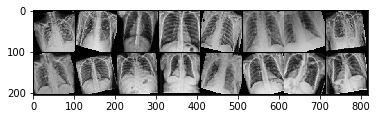

In [52]:
vis_dataloader = DataLoader(covid_dataset,
                            shuffle=True,
                            batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated).permute(1, 2, 0))
print(example_batch[2].numpy())

[1. 1. 0. 0. 0. 1. 0. 0.]


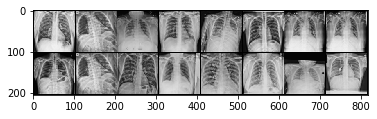

In [53]:
vis_dataloader_val = DataLoader(covid_dataset_val,
                                shuffle=False,
                                batch_size=8)
dataiter_val = iter(vis_dataloader_val)

example_batch = next(dataiter_val)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.imshow(torchvision.utils.make_grid(concatenated).permute(1, 2, 0))
print(example_batch[2].numpy())

In [54]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [74]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(16*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [75]:
train_dataloader = DataLoader(covid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [76]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = Adam(net.parameters(), lr = 0.0001)

In [77]:
counter = []
loss_history = [] 
iteration_number= 0

In [78]:
for epoch in range(0, EPOCHS):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

Epoch number 0
 Current loss 1.6270337104797363

Epoch number 0
 Current loss 1.1255797147750854

Epoch number 0
 Current loss 1.1264774799346924

Epoch number 0
 Current loss 1.171659231185913

Epoch number 0
 Current loss 1.128777027130127

Epoch number 0
 Current loss 1.1313263177871704

Epoch number 0
 Current loss 1.124442219734192

Epoch number 0
 Current loss 1.132333755493164

Epoch number 0
 Current loss 1.0437848567962646

Epoch number 0
 Current loss 1.104827880859375

Epoch number 0
 Current loss 1.0976706743240356

Epoch number 0
 Current loss 1.0961421728134155

Epoch number 0
 Current loss 1.0997087955474854

Epoch number 0
 Current loss 1.0663549900054932

Epoch number 0
 Current loss 1.0966644287109375

Epoch number 0
 Current loss 1.0907344818115234

Epoch number 0
 Current loss 1.1080045700073242

Epoch number 0
 Current loss 1.0991737842559814

Epoch number 0
 Current loss 1.0522204637527466

Epoch number 0
 Current loss 1.0982309579849243

Epoch number 0
 Current l

KeyboardInterrupt: 

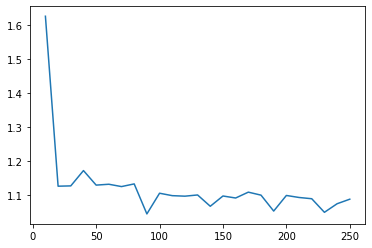

In [79]:
plt.plot(counter,loss_history)
plt.show()

In [101]:
test_dataloader = DataLoader(covid_dataset_val,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
acts = []
preds = []
for i in tqdm(range(20)):
    img0, img1 , label = next(dataiter)
    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
    output1,output2 = net(img0,img1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    # print(euclidean_distance.detach().cpu().numpy()[0], label.detach().cpu().numpy()[0])
    acts.append(label.detach().cpu().numpy()[0])
    preds.append(euclidean_distance.detach().cpu().numpy()[0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.64it/s]


In [105]:
from sklearn.metrics import roc_auc_score

roc_auc_score(acts, preds)

0.37373737373737376